In [1]:
import numpy as np
from qiskit import QuantumCircuit

In [2]:
# Create a Quantum Circuit acting on a quantum register of three qubits
circ = QuantumCircuit(4)

data = [1,1,1]

# Set input bites
for idx, i in enumerate(data):
    if i:
        circ.x(idx)

In [3]:
# Add a H gate on qubit 0, putting this qubit in superposition.
# circ.ch(0, 3)
# circ.ch(1, 4)
# circ.ch(2, 5)
circ.h(0)
circ.h(1)
circ.h(2)
circ.h(3)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
# circ.cx(1, 4)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
# circ.cx(2, 5)

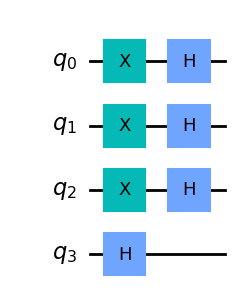

In [4]:
circ.draw('mpl')

In [5]:
from qiskit.quantum_info import Statevector

# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**4)

# Evolve the state by the quantum circuit
state = state.evolve(circ)

#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

In [6]:
from qiskit.visualization import array_to_latex

#Alternative way of representing in latex
array_to_latex(state)

<IPython.core.display.Latex object>

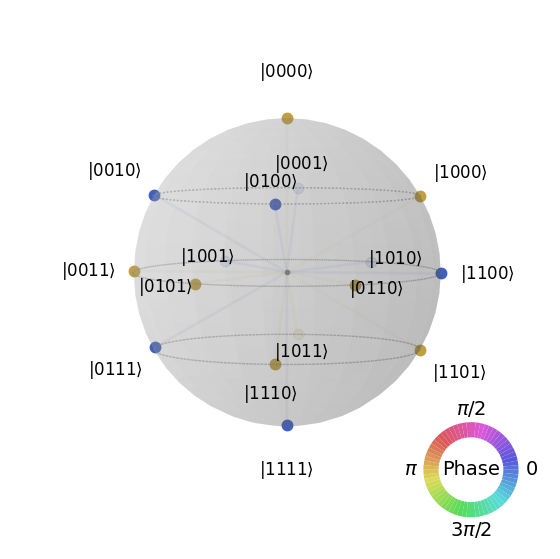

In [7]:
state.draw('qsphere')

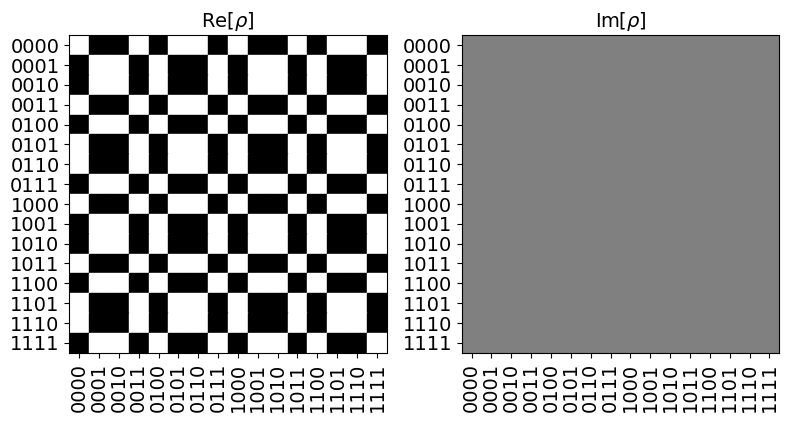

In [8]:
state.draw('hinton')

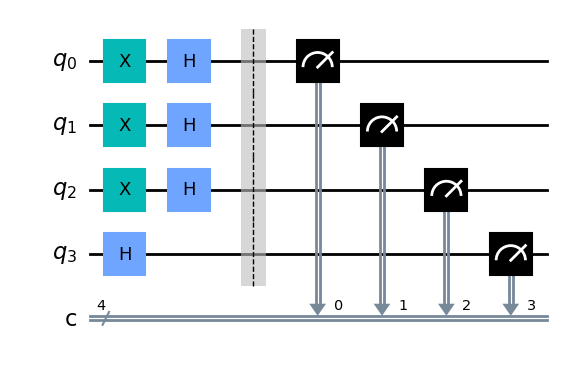

In [9]:
# Create a Quantum Circuit
meas = QuantumCircuit(4, 4)
meas.barrier(range(4))
# map the quantum measurement to the classical bits
meas.measure(range(4), range(4))

# The Qiskit circuit object supports composition.
# Here the meas has to be first and front=True (putting it before) 
# as compose must put a smaller circuit into a larger one.
qc = meas.compose(circ, range(4), front=True)

#drawing the circuit
qc.draw('mpl')

In [10]:
# Adding the transpiler to reduce the circuit to QASM instructions
# supported by the backend
from qiskit import transpile 

# Use AerSimulator
from qiskit.providers.aer import AerSimulator

backend = AerSimulator()

# First we have to transpile the quantum circuit 
# to the low-level QASM instructions used by the 


qc.save_statevector(label = 'test', pershot = True)
# backend
qc_compiled = transpile(qc, backend)

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
x = 10
y = 10
job_sim = backend.run(qc_compiled, shots=x*y, memory=True)

# Grab the results from the job.
result_sim = job_sim.result()

memory = result_sim.get_memory(0)
print(memory)
print(len(memory))
# result = execute(qc2, backend = backend, shots = 10).result()
# for i in range(0,5):
#     print(result_sim.data(0)['test'][i].probabilities(qargs=None, decimals=0))

['0001', '1000', '1011', '1010', '0001', '0110', '0100', '0100', '0011', '1100', '1011', '1100', '0010', '1011', '0011', '0110', '1000', '0001', '1000', '0100', '1001', '0011', '1111', '1101', '0000', '1011', '1000', '1101', '1101', '0000', '0111', '1001', '1000', '1011', '1011', '1010', '0010', '0011', '1011', '1100', '1001', '0111', '0100', '0010', '0011', '0110', '1001', '0001', '0110', '0001', '1101', '0101', '0100', '1010', '1011', '1001', '1100', '1010', '1010', '1010', '0001', '0100', '1000', '0111', '1100', '1100', '0011', '0000', '1111', '1001', '1000', '0011', '0010', '1011', '0000', '1010', '0011', '1110', '1110', '0111', '0011', '0001', '1101', '1111', '0110', '0111', '1000', '1100', '0110', '1011', '0111', '0011', '0010', '0101', '0100', '0000', '1101', '0111', '1000', '0100']
100


In [11]:
counts = result_sim.get_counts(qc_compiled)
print(counts)

{'1110': 2, '0001': 7, '1111': 3, '1100': 7, '0101': 2, '1001': 6, '1011': 10, '0111': 7, '0011': 10, '1010': 7, '1000': 9, '0110': 6, '1101': 6, '0100': 8, '0000': 5, '0010': 5}


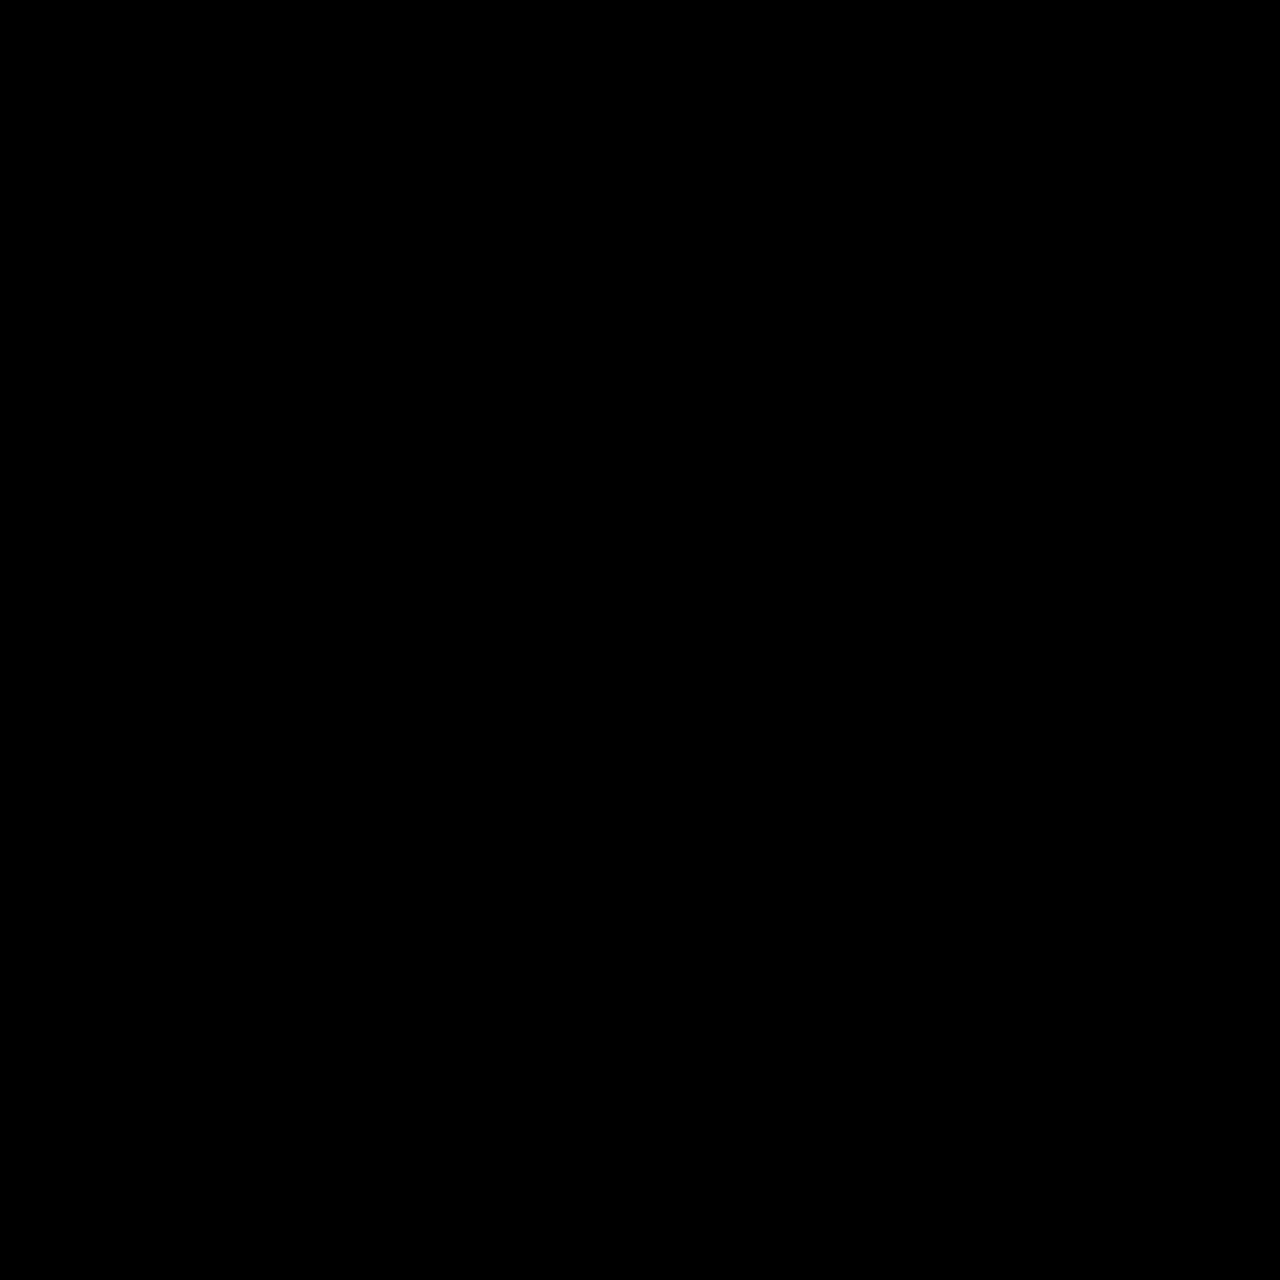

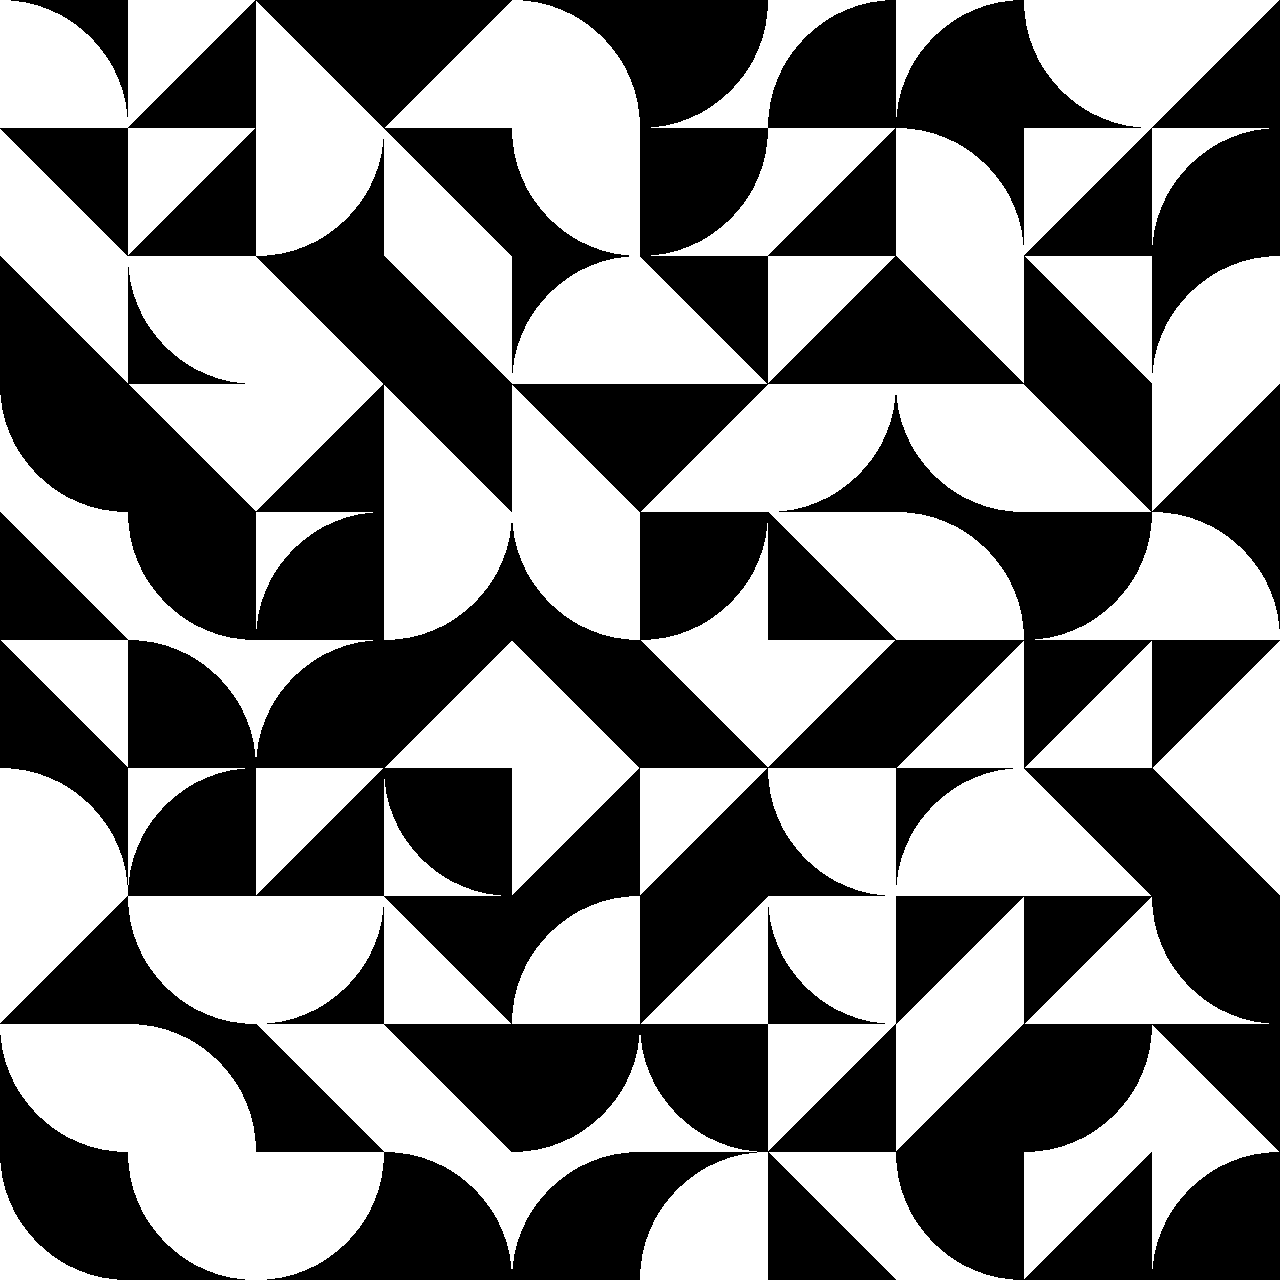

In [19]:
from PIL import Image, ImageDraw, ImageFilter

image = Image.new(mode="RGB", size=(x*128, y*128))
display(image)

for idx, i in enumerate(memory):
    tile_x = idx % x
    tile_y = idx // x
    im = Image.open('images/'+i+'.png')
    image.paste(im, (tile_x*128, tile_y*128))
image.save('output.png', quality=100)
display(image)

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)